Thymio mini project

In [1]:
!pip install --upgrade tdmclient

In [47]:
# import libraries
import time
from tdmclient import ClientAsync
import numpy as np
import math

# import project files
import constants as cst
import extended_Kalman_filter as eKf
import vision
import local_navigation as ln
import geometry as geo


In [48]:
from tdmclient import ClientAsync
client = ClientAsync()
node = await client.wait_for_node()
await node.lock()

Node 101c2fd7-1c04-4e4c-911d-5b3f3b0c1cc6

In [49]:
await node.set_variables({
            'leds.bottom.left': [0, 0, 0],
            'leds.bottom.right': [0, 0, 0],
            'leds.circle': [0, 0, 0, 0, 0, 0, 0, 0],
            'leds.top': [0, 0, 0],
        })

In [50]:
# Set the motor speeds
async def stop_robot():
    """
    Stop the robot. Set the motor speed of each wheel to zero.
    """
    await node.set_variables({
            "motor.right.target": [0],
            "motor.left.target": [0],
        })

async def move_robot(right_speed, left_speed):
    """
    Turn the robot wheels to the given speeds.
    Parameter: - right_speed   : right wheel speed in [thymio speed]
               - left_speed    : left wheel speed in [thymio speed]
    """
    await node.set_variables({
            "motor.right.target": [right_speed],
            "motor.left.target": [left_speed],
        })

In [51]:
# Get the proximity sensor values
async def get_prox_sensors():
    """
    Get the sensor measurements of a the proximity sensors.
    Returns: - prox_sensors    : numpy array of fron proximity sensors measurements
             - detected        : boolean, true if any sensors measured a higher value than threshold
    """
    
    await node.wait_for_variables({str('prox.horizontal')})
    prox_sensors = np.asarray(list(node['prox.horizontal']))
    prox_sensors = prox_sensors[0:5]

    prox_sensors_bool = (prox_sensors >= np.ones(5) * 20) #cst.THRESHOLD_PROX_SENSOR
    detected = False
    if(any(prox_sensors_bool)):
        detected = True

    return prox_sensors, detected

# Get the motor speed measurement values
async def get_motor_speed_meas():
    """
    Get the motor speed measurements
    Returns: - speed_left_meas    : left wheel speed in [thymio speed]
             - speed_right_meas   : right wheel speed in [thymio speed]
    """
    
    await node.wait_for_variables({str('motor.right.speed')})
    speed_right_meas = node['motor.right.speed']
    await node.wait_for_variables({str('motor.left.speed')})
    speed_left_meas = node['motor.left.speed']

    return speed_right_meas, speed_left_meas

In [52]:
# test thymio
# move the robot forward and get prox values.
await move_robot(50, 50)
dt = 0
old_time = time.time()
while(dt < 2):
    y,d = await get_prox_sensors()
    print(y)
    print(d)
    await client.sleep(0.1)
    dt = time.time() - old_time
await stop_robot()

[0 0 0 0 0]
False
[0 0 0 0 0]
False
[0 0 0 0 0]
False
[0 0 0 0 0]
False
[0 0 0 0 0]
False
[0 0 0 0 0]
False
[0 0 0 0 0]
False
[0 0 0 0 0]
False
[0 0 0 0 0]
False
[0 0 0 0 0]
False
[0 0 0 0 0]
False
[0 0 0 0 0]
False
[0 0 0 0 0]
False
[0 0 0 0 0]
False
[0 0 0 0 0]
False
[0 0 0 0 0]
False


In [55]:
# ROBOT CONTROL AND VISION

# state variables
global_state = 'rotation'

### initialisation
# vision (détection robot, obstacles, goal)
#obstacles, goal_centroid, robot_centroid, robot_direction = vision.vision_obstacles_positions()
# global nav

#robot, robot_direction = vision.vision_robot()
#robot_orientation = np.arctan2(robot_direction[0], robot_direction[1])
#robot = robot * 0.308

intermediate_goals = [(0, 10), (10, 10), (10, 0), (0,0)]
robot_position = [0.0,0.0]
robot_orientation = math.pi / 2.0
robot_speed = [0.0,0.0]
speed_correction = 0

Kfilter = eKf.Kalman(robot_position[0], robot_position[1], robot_orientation)


old_time = 0.0

iter = 0
while(True):
    print(iter)
    if intermediate_goals == []:
        await stop_robot()
        print("stop robot")
        break

    # vision et gobale toutes les n iterations (i modulo n == 0)
    
    # get robot sensor values
    prox_sensors, detected = await get_prox_sensors()
    # test if local (with proximity)
    #if(detected):
    #    global_state = 'local_avoidance'
    
     #if(iter % 10 == 0):
    #    robot_centroid, robot_direction = vision.vision_robot()
    #    robot_centroid = robot_centroid * 0.308
    #    robot_angle = np.arctan2(robot_direction[0], robot_direction[1])
    #    Kfilter.measurement_position(robot_centroid[0], robot_centroid[1], robot_angle)

    speed_right_meas, speed_left_meas = await get_motor_speed_meas()
    Kfilter.measurement_wheels(speed_right_meas*speed_correction / 18.1818, speed_left_meas*speed_correction / 18.1818) 

    if iter == 0:                   # first time
        old_time = time.time()
    dt = time.time() - old_time     # get time difference for Kalman
    # print("dt: ", dt)
    # Kalman (with wheel speed and camera position)
    old_time = time.time()
    
    Kfilter.dt_update(dt)
    Kfilter.Kalman_filter()

    print("Kalman: ", Kfilter.Mu[0][0], Kfilter.Mu[1][0], Kfilter.Mu[2][0], Kfilter.Mu[3][0], Kfilter.Mu[4][0])

    if global_state == 'rotation':
        angle = np.arctan2(intermediate_goals[0][1] - Kfilter.Mu[1][0], intermediate_goals[0][0] - Kfilter.Mu[0][0]) - Kfilter.Mu[2][0]
        angle = geo.center_angle(angle)
        print("rotation", "angle but : ", np.arctan2(intermediate_goals[0][1] - Kfilter.Mu[1][0], intermediate_goals[0][0] - Kfilter.Mu[0][0]), "angle robot : ",  Kfilter.Mu[2][0], " angle: ", angle)
        
        if abs(angle) < 0.1:
            await stop_robot()
            global_state = 'translation'
            continue

        # call rotation fct
        if(angle > 0):
            robot_speed = [30, -30]         # counterclockwise
            speed_correction = 12.5 #32 #12.5
        else:
            robot_speed = [-30, 30]         # clockwise
            speed_correction = 14 #25 #14

        await move_robot(robot_speed[0], robot_speed[1])
        

    elif global_state == 'translation':
        print("translation ", np.sqrt((intermediate_goals[0][0] - Kfilter.Mu[0][0])**2 + (intermediate_goals[0][1] - Kfilter.Mu[1][0])**2))
        
        if np.sqrt((intermediate_goals[0][0] - Kfilter.Mu[0][0])**2 + (intermediate_goals[0][1] - Kfilter.Mu[1][0])**2) < 2:
            await stop_robot()
            intermediate_goals.pop(0)
            global_state = 'rotation'
            continue

        # call translation fct
        robot_speed = [50, 50]
        speed_correction = 0.75
        await move_robot(robot_speed[0], robot_speed[1])

    elif global_state == 'local_avoidance':
        # call local_avoidance fct (= add obstacle on global map and recompute global nav)
        robot_direction = (math.cos(Kfilter.Mu[2][0]), math.sin(Kfilter.Mu[2][0]))
        # Object = ln.local_nav([Kfilter.Mu[0][0], Kfilter.Mu[1][0]], robot_direction, prox_sensors)
        object_robot_coords = ln.object_robot_coordinates(prox_sensors)
        print("obstacle in robot coord", object_robot_coords)
        print([Kfilter.Mu[0][0], Kfilter.Mu[1][0]])
        object_ground_coords = ln.robot_to_ground_coords([Kfilter.Mu[0][0], Kfilter.Mu[1][0]], robot_direction, object_robot_coords)
        print("obstacle in ground coord", object_ground_coords)
        Object = ln.safety_zone(object_ground_coords)
        print("obstacle square", Object)
        await stop_robot()
        break
        
        global_state = 'rotation'
    time.sleep(0.1)

    iter = iter + 1

0
Kalman:  0.0 0.0 1.5707963267948966 0.0 0.0
rotation angle but :  1.5707963267948966 angle robot :  1.5707963267948966  angle:  0.0
0
Kalman:  0.0 0.0 1.5707963267948966 0.0 0.0
translation  10.0
1
Kalman:  0.0 0.0 1.5707963267948966 0.0 0.0
translation  10.0
2
Kalman:  3.37722044422853e-19 0.005515419542320091 1.5708259795881347 0.10191193491294281 0.0
translation  9.99448458045768
3
Kalman:  -2.6102703441197457e-06 0.1278268618958248 1.5708454153221487 0.9821223805747721 0.9941730041834018
translation  9.87217313810452
4
Kalman:  -1.0924138413911872e-05 0.3939634536680605 1.570892229208439 1.5733444747754712 1.424985869694779
translation  9.606036546338151
5
Kalman:  -6.0132581976915335e-05 0.7405043743673952 1.5708568619484984 1.7226967334856083 1.920967620458536
translation  9.25949562582786
6
Kalman:  -6.847972746147003e-05 1.126278176727375 1.5708232336064043 1.9072141191194076 1.8809710633382595
translation  8.873721823536858
7
Kalman:  -9.612955074331414e-05 1.523998397172047

In [53]:
intermediate_goals = [(0, 10), (10, 10), (10, 0), (0,0)]
robot_position = [0.0,0.0]
robot_orientation = 0
robot_speed = [0.0,0.0]
speed_correction = 0

Kfilter = eKf.Kalman(robot_position[0], robot_position[1], robot_orientation)

angle = np.arctan2(intermediate_goals[0][1] - Kfilter.Mu[1][0], intermediate_goals[0][0] - Kfilter.Mu[0][0]) - Kfilter.Mu[2][0]
angle = geo.center_angle(angle)
print("rotation", "angle but : ", np.arctan2(intermediate_goals[0][1] - Kfilter.Mu[1][0], intermediate_goals[0][0] - Kfilter.Mu[0][0]), "angle robot : ",  Kfilter.Mu[2][0], " angle: ", angle)



rotation angle but :  1.5707963267948966 angle robot :  0.0  angle:  1.5707963267948966


In [54]:
await stop_robot()

In [51]:
#CODE TO CALIBRATE ROTATION/TRANSLATION

#speed_correction = 12.5 #calibration cst for rotation counterclockwise
speed_correction = 14 #calibration cst for rotation counterclockwise
#speed_correction = 0.75 #0.65 #calibration cst for translation


#intermediate_goals = [(0, 1)]
robot = [0.0,0.0]
robot_orientation = 0
robot_speed = [0.0,0.0]

Kfilter = eKf.Kalman(robot[0], robot[1], robot_orientation)

#robot_speed = [30, -30] #robot speed for rotation (counterclockwise)
robot_speed = [-30, 30] #robot speed for rotation (clockwise)
#robot_speed = [50, 50] #robot speed for translation
await move_robot(robot_speed[0], robot_speed[1])

old_time = 0.0

iter = 0
while(True):
    iter = iter + 1
    print(iter)

    speed_right_meas, speed_left_meas = await get_motor_speed_meas()
    speed_right_meas = speed_right_meas * speed_correction
    speed_left_meas = speed_left_meas * speed_correction
    Kfilter.measurement_wheels(speed_right_meas / 18.1818, speed_left_meas / 18.1818)

    if iter == 0:                   # first time
        old_time = time.time()
    dt = time.time() - old_time     # get time difference for Kalman
    old_time = time.time()

    Kfilter.dt_update(dt)
    Kfilter.Kalman_filter()
    print(dt, time.time(), old_time)
    print("Kalman: ", Kfilter.Mu[0][0], Kfilter.Mu[1][0], Kfilter.Mu[2][0], Kfilter.Mu[3][0], Kfilter.Mu[4][0])

    if(abs(Kfilter.Mu[2][0]) > np.pi / 4.0):        #rotation condition
    #if(np.sqrt(Kfilter.Mu[0][0]**2 + Kfilter.Mu[1][0]**2) > 15.0):     #translation condition
        await stop_robot()
        print("stop")
        break

    await client.sleep(0.1)

1
1701763128.9552555 1701763128.9552555 1701763128.9552555
Kalman:  0.0 0.0 0.0 0.0 0.0
2
0.10266828536987305 1701763129.0579238 1701763129.0579238
Kalman:  0.0 0.0 0.0 0.0 0.0
3
0.10953497886657715 1701763129.1674588 1701763129.1674588
Kalman:  -0.02554475670121159 0.0 -0.002197403406818121 -8.055398071624982 7.107704180845572
4
0.11037397384643555 1701763129.278906 1701763129.2778327
Kalman:  -0.08929283760223082 0.00011492501275058122 -0.007681119287736585 -11.165015303446248 9.8514840912761
5
0.11058831214904785 1701763129.3891656 1701763129.388421
Kalman:  -0.15081730297669022 0.0005528362766846919 -0.015764752402669398 -16.16136937993937 15.183727990257456
6
0.10869812965393066 1701763129.4971192 1701763129.4971192
Kalman:  -0.19966096183031223 0.0013167125698664763 -0.025632054155542424 -18.07023580446218 17.220921750007225
7
0.11301755905151367 1701763129.6101367 1701763129.6101367
Kalman:  -0.2949658381097165 0.003480749392988359 -0.037598493771621125 -22.130583406196937 19.90

In [46]:
await stop_robot()

In [55]:
#CODE TO CALIBRATE ROTATION/TRANSLATION

# state variables
global_state = 'rotation'

#speed_correction = 12.5 #calibration cst for rotation counterclockwise
speed_correction = 14 #calibration cst for rotation counterclockwise
#speed_correction = 0.75 #0.65 #calibration cst for translation


#intermediate_goals = [(0, 10), (-10, 10), (-10, 0), (0,0)]
intermediate_goals = [(0, -10), (-10, -10), (-10, 0), (0,0)]
robot = [(0.0,0.0)]
robot_orientation = 0
robot_speed = [0.0,0.0]

Kfilter = eKf.Kalman(robot[0][0], robot[0][1], robot_orientation)

#robot_speed = [30, -30] #robot speed for rotation (counterclockwise)
#robot_speed = [-30, 30] #robot speed for rotation (clockwise)
#robot_speed = [50, 50] #robot speed for translation
#await move_robot(robot_speed[0], robot_speed[1])

old_time = 0.0

iter = 0
while(True):
    iter = iter + 1
    print(iter, global_state)

    if intermediate_goals == []:
        await stop_robot()
        print("stop robot")
        break

    speed_right_meas, speed_left_meas = await get_motor_speed_meas()
    print(speed_right_meas, speed_left_meas, "  ", robot_speed[0], robot_speed[1])
    speed_right_meas = speed_right_meas * speed_correction
    speed_left_meas = speed_left_meas * speed_correction
    
    #speed_right_meas = robot_speed[0] * speed_correction
    #speed_left_meas = robot_speed[1] * speed_correction

    Kfilter.measurement_wheels(speed_right_meas / 18.1818, speed_left_meas / 18.1818)

    if iter == 0:                   # first time
        old_time = time.time()
    dt = time.time() - old_time     # get time difference for Kalman
    old_time = time.time()

    Kfilter.dt_update(dt)
    Kfilter.Kalman_filter()
    #print(dt, time.time(), old_time)
    print("Kalman: ", Kfilter.Mu[0][0], Kfilter.Mu[1][0], Kfilter.Mu[2][0], Kfilter.Mu[3][0], Kfilter.Mu[4][0])
    #print("Kalman Sigma: ", Kfilter.Sigma)
    #print("Kalman y: ", Kfilter.y)
    
    robot.append((Kfilter.Mu[0][0], Kfilter.Mu[1][0]))
    
    if global_state == 'rotation':
        angle = np.arctan2(intermediate_goals[0][1] - Kfilter.Mu[1], intermediate_goals[0][0] - Kfilter.Mu[0]) - Kfilter.Mu[2]
        angle2 = geo.center_angle(angle)
        print(Kfilter.Mu[2], np.arctan2(intermediate_goals[0][1] - Kfilter.Mu[1], intermediate_goals[0][0] - Kfilter.Mu[0]), angle, angle2)
        #if(abs(Kfilter.Mu[2][0]) > np.pi / 4.0):        #rotation condition
        if(abs(angle) < 0.1):
            await stop_robot()
            global_state = 'translation'
            continue

        if(angle > 0):
            robot_speed = [30, -30]         # counterclockwise
            speed_correction = 24 #32 #14
        else:
            robot_speed = [-30, 30]         # clockwise
            speed_correction = 25 #12.5

    elif global_state == 'translation':
        robot_speed = [50, 50]
        speed_correction = 0.75
        #if(np.sqrt(Kfilter.Mu[0][0]**2 + Kfilter.Mu[1][0]**2) > 10.0):     #translation condition
        if np.sqrt((intermediate_goals[0][0] - Kfilter.Mu[0])**2 + (intermediate_goals[0][1] - Kfilter.Mu[1])**2) < 2:
            await stop_robot()
            intermediate_goals.pop(0)
            global_state = 'rotation'
            continue

    await move_robot(robot_speed[0], robot_speed[1])
    await client.sleep(0.05)


    

1 rotation
53 49    0.0 0.0
Kalman:  5.462276719755158e-10 0.0 4.047121867899167e-09 20.40502040502041 18.865018865018865
[4.04712187e-09] [-1.57079633] [-1.57079633] [-1.57079633]
2 rotation
-19 23    -30 30
Kalman:  7.6364593765838915 3.18308384539099e-07 -0.013028087936304732 -7.513025413465037 26.52103142989904
[-0.01302809] [-2.22297377] [-2.20994568] [-2.20994568]
3 rotation
-27 28    -30 30
Kalman:  8.600753135983021 -0.010119113287311233 -0.03721225079367686 -25.73581406906413 33.89273303090079
[-0.03721225] [-2.28161118] [-2.24439893] [-2.24439893]
4 rotation
-27 28    -30 30
Kalman:  9.060993659480436 -0.02840504396971224 -0.06748542624002528 -32.77033888229376 36.738423600441486
[-0.06748543] [-2.30838662] [-2.2409012] [-2.2409012]
5 rotation
-27 28    -30 30
Kalman:  9.317491753054737 -0.04679736058239128 -0.10103116621083107 -35.461446327733 37.82706274557676
[-0.10103117] [-2.32321797] [-2.2221868] [-2.2221868]
6 rotation
-30 29    -30 30
Kalman:  9.387098462584186 -0.055

In [46]:
await stop_robot()

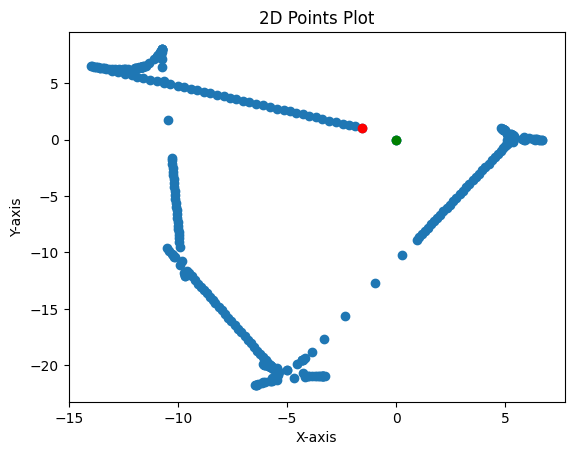

[(0.0, 0.0), (4.904857176950536e-10, 0.0), (5.100241998075736, -5.805340585036548e-08), (5.894563745483428, 0.002081239700782884), (6.372233143090375, -0.0018785105792781817), (6.615819275351563, -0.010736902277441611), (6.7025414377263175, -0.0169979446634544), (6.695484785181797, -0.01740255679874908), (6.57554805855805, -0.00286084151181816), (6.476529631538995, 0.015416502406885878), (6.442345899693904, 0.023076266236370817), (6.384924488036486, 0.036322186469561916), (6.298312584317017, 0.06046281119602779), (6.111123735862305, 0.11842249651112852), (5.8562609243333394, 0.20992643687379672), (5.347960437818281, 0.40842383440643315), (5.100840870038255, 0.5296147811091237), (5.112941602507061, 0.5251730728930959), (5.177199670798623, 0.4911005119669419), (5.15043283477093, 0.503718961356019), (5.4347477944087395, 0.33379095567466843), (5.798271352706005, 0.078098919687879), (5.907800977956527, -0.0095200340711947), (5.840439247306232, 0.042083517720785626), (5.363198847179184, 0.43

In [54]:
import matplotlib.pyplot as plt

# Unpack the tuples into separate lists for x and y coordinates
x_coords, y_coords = zip(*robot)

# Plot the points
plt.scatter(x_coords, y_coords)
plt.scatter(robot[0][0], robot[0][1], color = "green")
plt.scatter(robot[-1][0], robot[-1][1], color = "red")

# Add labels and title
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('2D Points Plot')

# Display the plot
plt.show()
print(robot)